# Design check of suppression electrode

- 2D axissymmetric study
- Ring around the hole where the beam passes through
- Target HV is -100 kV
- Parameter study:
    - Distance between the two rings where the beam passes through
    D.hole = 3 to 12 mm
    - Distance between the surface of the target and the inner surface of the suppression electrode
    D.electrode_target = 5 to 35 mm
    - Length of the bottom piece of the suppression electrode down towards the pump
    L.suppr_bottom = 15 to 100 mm
    - Done for 500, 750, 1250, and 1500 V negative bias of the suppression electrode
    

In [300]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import re
from itertools import islice
from matplotlib.colors import ListedColormap

In [2]:
folder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/04.suppr_elec/data.esEx/'

files = [f for f in os.listdir(folder) if f.endswith('.csv')]
files

['04.suppr_elec.2D.001.Vbias_1000V.csv',
 '04.suppr_elec.2D.001.Vbias_1250V.csv',
 '04.suppr_elec.2D.001.Vbias_750V.csv',
 '04.suppr_elec.2D.001.Vbias_500V.csv',
 '04.suppr_elec.2D.001.Vbias_1500V.csv']

In [3]:
def file_read_from_head(fname, nlines):
    c = []    
    with open(fname) as f:
        for line in islice(f, nlines):
            c.append(line.rstrip())
    f.close()
    return c
    


The structure of the data file is:

- first column is the x value in mm
- rest 320 columns are es.Ex in kV/mm for various combinations of
    - D.hole, D.electrode_target, L_suppr_bottom<br>
    
    
    
    
- it is for example "es.Ex (kV/mm) @ D.hole=3, D.electrode_target=5" one column or
- "es.Ex (kV/mm) @ D.hole=4.2857, D.electrode_target=5, L.suppr_bottom=36.25" is another one

In [4]:
lst_df = []

for file in files:
    V_bias = re.findall(r'Vbias_(\d*)V', file)[0]
    file = f'{folder}{file}'
    
    df_t = pd.read_csv(file, skiprows=8, header=None)
    num_cols = len(df_t.columns)  # number of columns in the dataframe
    
    # find column headers
    c = file_read_from_head(file, 8)[-1]
    
    # split on the es.Ex
    c_list = c.split('es.Ex')
    
    c_list[0] = 'x_mm'
    assert len(c_list) == num_cols
    


    df_t.columns = c_list
    

    df_t['V_bias'] = V_bias    
    
    lst_df.append(df_t)

## one df: Check which parameter values there are

In [215]:
df = lst_df[2]
print(df['V_bias'].unique())
cols = df.columns

Dhole_values = []
DelTarget_values = []
LsupprBottom = []

cols = [c for c in cols if 'kV/mm' in c]
# print(cols)

for c in cols:
    Dhole_values.append(float(re.findall(r'D.hole=(.*[^,]), D.e', c)[0]))
    DelTarget_values.append(float(re.findall(r'D.electrode_target=(.*[^,]), L.s', c)[0]))
    LsupprBottom.append(float(re.findall(r'L.suppr_bottom=(.*[^,])', c)[0]))

# print(cols)
    
def returnListAsUniqueArray(in_list):
    t = np.asarray(in_list)
    return np.unique(t)

Dhole_values = returnListAsUniqueArray(Dhole_values)
DelTarget_values = returnListAsUniqueArray(DelTarget_values)
LsupprBottom = returnListAsUniqueArray(LsupprBottom)

print(f'Dhole_values: {Dhole_values} mm')
print(f'DelTarget_values: {DelTarget_values} mm')
print(f'LsupprBottom: {LsupprBottom} mm')


['750']
Dhole_values: [ 3.      4.2857  5.5714  6.8571  8.1429  9.4286 10.714  12.    ] mm
DelTarget_values: [ 5.      9.2857 13.571  17.857  22.143  26.429  30.714  35.    ] mm
LsupprBottom: [ 15.    36.25  57.5   78.75 100.  ] mm


## Construct binary filter if suppression or no suppression

In [216]:
df = lst_df[2]
x_target = 87.94  # x position of the target

# check if the last 10 values at the target surface are larger than 0, if so, then electrons are not suppressed
x_range = -10
df = df[ df['x_mm'] < x_target ]
df = df.iloc[x_range:,:]

print(df['x_mm'].values)
df_t =  df.loc[:,cols] > 0 
a = df_t.sum()
# print(a[ a == 5 ])

df_suppr = pd.DataFrame()

def processCols(row):
#     print(row)
    n = row.name
    
    Dhole = (float(re.findall(r'D.hole=(.*[^,]), D.e', n)[0]))
    DelecTarget = (float(re.findall(r'D.electrode_target=(.*[^,]), L.s', n)[0]))
    LsupprBott = (float(re.findall(r'L.suppr_bottom=(.*[^,])', n)[0]))
    
    suppr_bool = np.sum(row.values)
#     suppressed = -1
    if suppr_bool > 0:
        supressed = 0
    else:
        supressed = 1
#     print(suppressed)
#     print(type(Dhole),type(DelecTarget),type(LsupprBott),type(supp_bool))
    s = pd.Series([Dhole, DelecTarget, LsupprBott, supressed], index=['Dhole', 'DelecTarget', 'LsupprBott', 'supressed'])

    return s


df_suppr = df_t.apply(lambda x: processCols(x), axis=0)
df_suppr= df_suppr.T.reset_index(drop=True)

df_suppr['V_bias'] = df['V_bias'].unique()[0]
# df_suppr[['Dhole', 'DelecTarget', 'LsupprBott', 'supp_bool']]
print(df_suppr)

[85.5  85.75 86.   86.25 86.5  86.75 87.   87.25 87.5  87.75]
       Dhole  DelecTarget  LsupprBott  supressed V_bias
30    3.0000      30.7140       15.00        0.0    750
35    3.0000      35.0000       15.00        0.0    750
70    4.2857      30.7140       15.00        0.0    750
75    4.2857      35.0000       15.00        0.0    750
110   5.5714      30.7140       15.00        0.0    750
115   5.5714      35.0000       15.00        0.0    750
150   6.8571      30.7140       15.00        0.0    750
155   6.8571      35.0000       15.00        0.0    750
190   8.1429      30.7140       15.00        0.0    750
195   8.1429      35.0000       15.00        0.0    750
200   9.4286       5.0000       15.00        0.0    750
201   9.4286       5.0000       36.25        0.0    750
202   9.4286       5.0000       57.50        0.0    750
203   9.4286       5.0000       78.75        0.0    750
204   9.4286       5.0000      100.00        0.0    750
230   9.4286      30.7140       15.00     

## Do it in a loop for all dfs

In [250]:
lst_df_suppr = []
x_target = 87.94  # x position of the target
x_range = -10

def processCols(row):
#     print(row)
    n = row.name

    Dhole = (float(re.findall(r'D.hole=(.*[^,]), D.e', n)[0]))
    DelecTarget = (float(re.findall(r'D.electrode_target=(.*[^,]), L.s', n)[0]))
    LsupprBott = (float(re.findall(r'L.suppr_bottom=(.*[^,])', n)[0]))

    suppr_bool = np.sum(row.values)
#     suppressed = -1
    if suppr_bool > 0:
        supressed = 0
    else:
        supressed = 1
#     print(suppressed)
#     print(type(Dhole),type(DelecTarget),type(LsupprBott),type(supp_bool))
    s = pd.Series([Dhole, DelecTarget, LsupprBott, supressed], index=['Dhole', 'DelecTarget', 'LsupprBott', 'supressed'])

    return s

for df in lst_df:

    # check if the last 10 values at the target surface are larger than 0, if so, then electrons are not suppressed

    df = df[ df['x_mm'] < x_target ]
    df = df.iloc[x_range:,:]

#     print(df['x_mm'].values)
    df_t =  df.loc[:,cols] > 0 
    a = df_t.sum()
    # print(a[ a == 5 ])

    df_suppr = pd.DataFrame()


    df_suppr = df_t.apply(lambda x: processCols(x), axis=0)
    df_suppr= df_suppr.T.reset_index(drop=True)

    df_suppr['V_bias'] = float(df['V_bias'].unique()[0])


    lst_df_suppr.append(df_suppr)
    
df_suppr = pd.concat(lst_df_suppr)
df_suppr.head()

,Dhole,DelecTarget,LsupprBott,supressed,V_bias
0,3.0,5.0,15.00,1.0,1000.0
1,3.0,5.0,36.25,1.0,1000.0
2,3.0,5.0,57.50,1.0,1000.0
3,3.0,5.0,78.75,1.0,1000.0
4,3.0,5.0,100.00,1.0,1000.0


In [251]:
df_suppr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 0 to 319
Data columns (total 5 columns):
Dhole          1600 non-null float64
DelecTarget    1600 non-null float64
LsupprBott     1600 non-null float64
supressed      1600 non-null float64
V_bias         1600 non-null float64
dtypes: float64(5)
memory usage: 75.0 KB


In [262]:
df_suppr.describe()

,Dhole,DelecTarget,LsupprBott,supressed,V_bias
count,1600.000000,1600.000000,1600.000000,1600.00000,1600.000000
mean,7.499963,19.999963,57.500000,0.90250,1000.000000
std,2.946833,9.822916,30.061434,0.29673,353.663928
min,3.000000,5.000000,15.000000,0.00000,500.000000
25%,5.249975,12.499675,36.250000,1.00000,750.000000
50%,7.500000,20.000000,57.500000,1.00000,1000.000000
75%,9.749950,27.500250,78.750000,1.00000,1250.000000
max,12.000000,35.000000,100.000000,1.00000,1500.000000


In [263]:
df_suppr.V_bias.unique()

array([1000., 1250.,  750.,  500., 1500.])

In [273]:
df = df_suppr[ df_suppr['V_bias'] == 750 ]
Dhole_values = df['Dhole'].unique()
x = df['Dhole'].values
y = df['DelecTarget'].values
z = df['supressed'].values
# df_1 = df[ df['LsupprBott'] == 15 ]
df.head()

,Dhole,DelecTarget,LsupprBott,supressed,V_bias
0,3.0,5.0,15.00,1.0,750.0
1,3.0,5.0,36.25,1.0,750.0
2,3.0,5.0,57.50,1.0,750.0
3,3.0,5.0,78.75,1.0,750.0
4,3.0,5.0,100.00,1.0,750.0


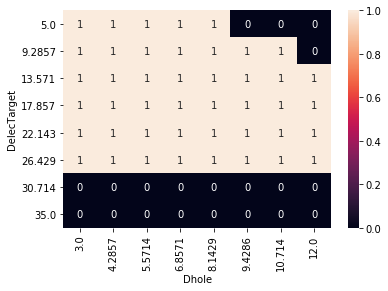

In [267]:
# pivot table
res = pd.pivot_table(df, values='supressed', index=['DelecTarget'], columns=['Dhole'])
sns.heatmap(res, annot=True)

In [248]:
res.head()

DelecTarget,5.0,9.2857,13.571,17.857,22.143,26.429,30.714,35.0
Dhole,,,,,,,,
3.0000,1.0,1.0,1.0,1.0,1.0,1.0,0.8,0.8
4.2857,1.0,1.0,1.0,1.0,1.0,1.0,0.8,0.8
5.5714,1.0,1.0,1.0,1.0,1.0,1.0,0.8,0.8
6.8571,1.0,1.0,1.0,1.0,1.0,1.0,0.8,0.8
8.1429,1.0,1.0,1.0,1.0,1.0,1.0,0.8,0.8


In [249]:
df_suppr['supressed'].unique()

array([1., 0.])

In [274]:
df['supressed'].unique()

array([1., 0.])

In [275]:
df.head()

,Dhole,DelecTarget,LsupprBott,supressed,V_bias
0,3.0,5.0,15.00,1.0,750.0
1,3.0,5.0,36.25,1.0,750.0
2,3.0,5.0,57.50,1.0,750.0
3,3.0,5.0,78.75,1.0,750.0
4,3.0,5.0,100.00,1.0,750.0


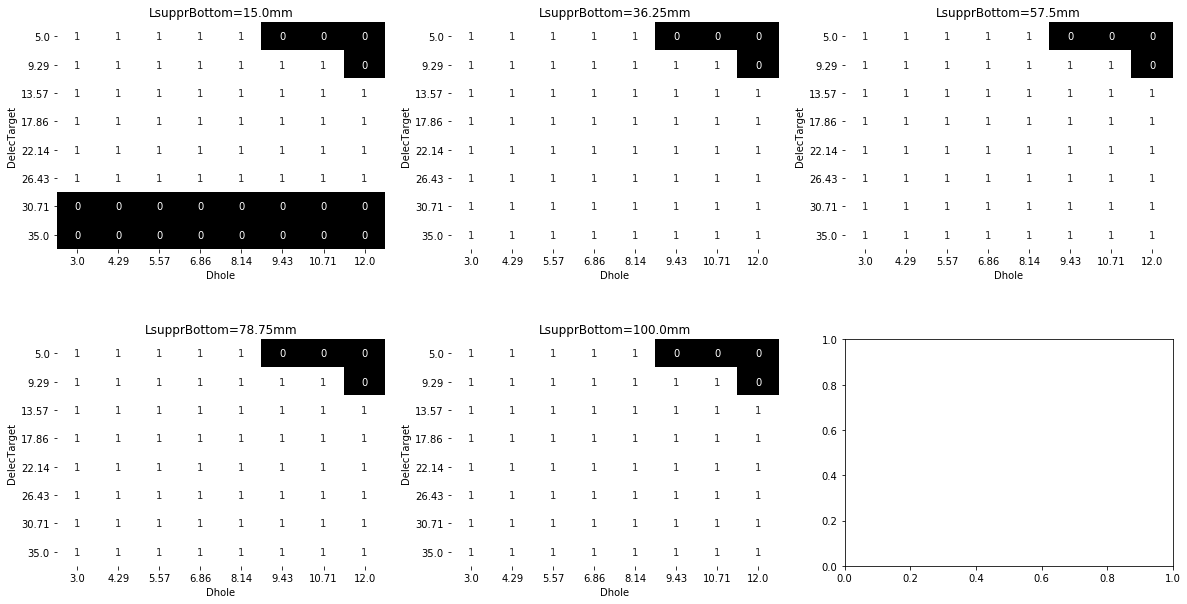

In [311]:
grouped = df.groupby('LsupprBott')
rowlength = int(np.ceil(grouped.ngroups/2))                         # fix up if odd number of groups

fig, axs = plt.subplots(figsize=(20,10), 
                        nrows=2, ncols=rowlength,     # fix as above
                        gridspec_kw=dict(hspace=0.4)) # Much control of gridspec

targets = zip(grouped.groups.keys(), axs.flatten())

for i, (key, ax) in enumerate(targets):

    g = grouped.get_group(key)

    res = pd.pivot_table(g, values='supressed', index=['DelecTarget'], columns=['Dhole'])
    sns.heatmap(res,annot=True, ax=ax,cmap='gray', cbar=False)
#     ax.set_title(f'LsupprBottom={key}, Vbias={V_bias}V')
    ax.set_title(f'LsupprBottom={key}mm')


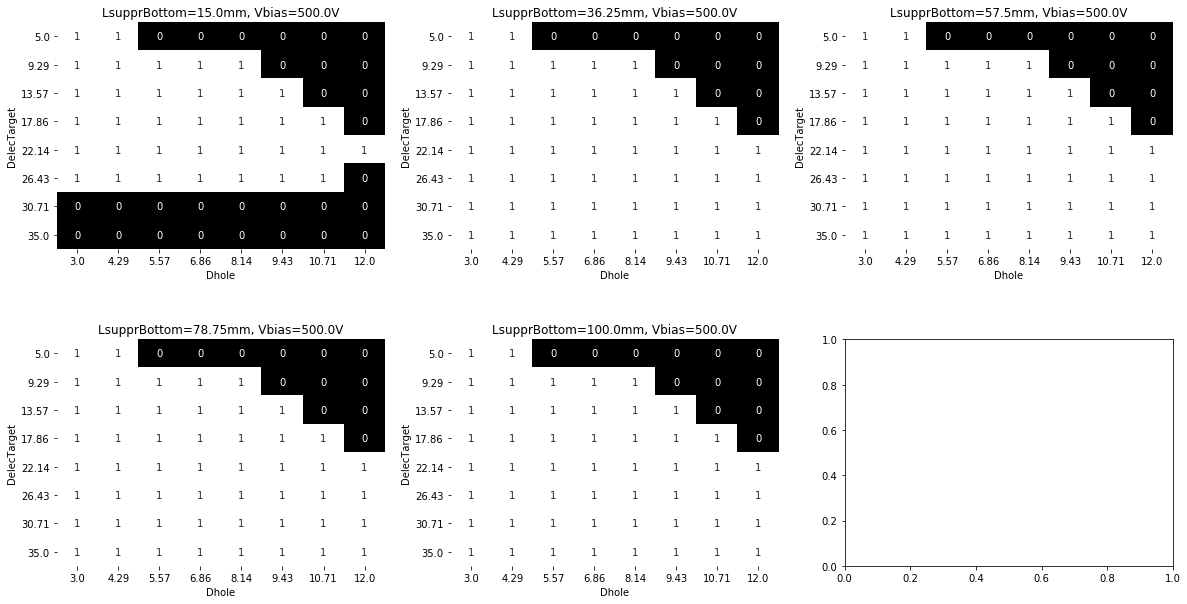

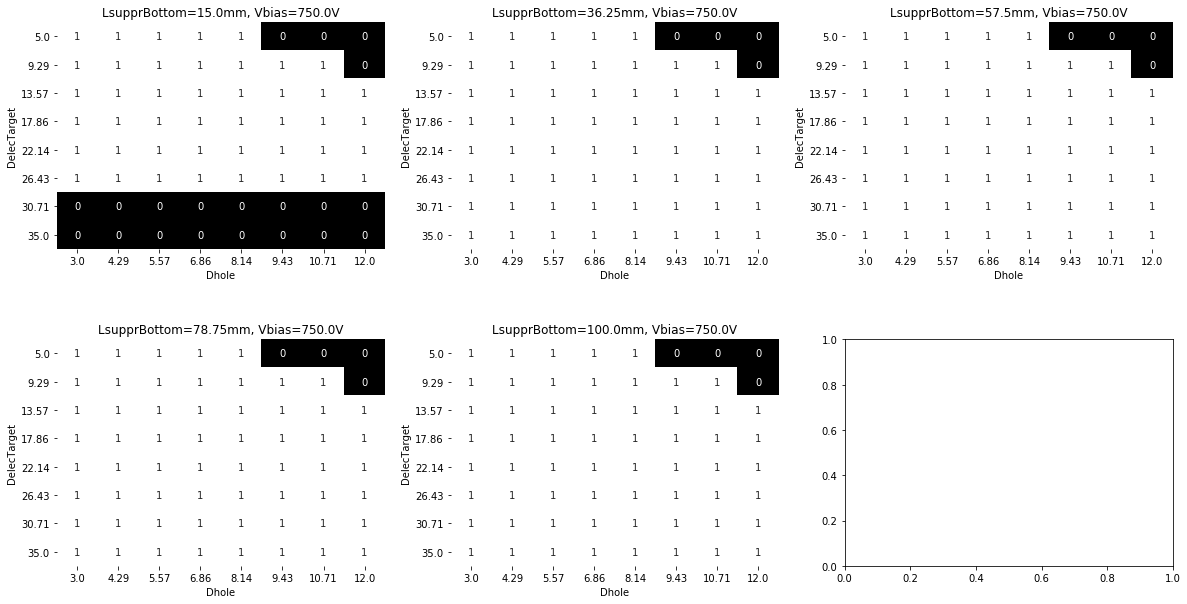

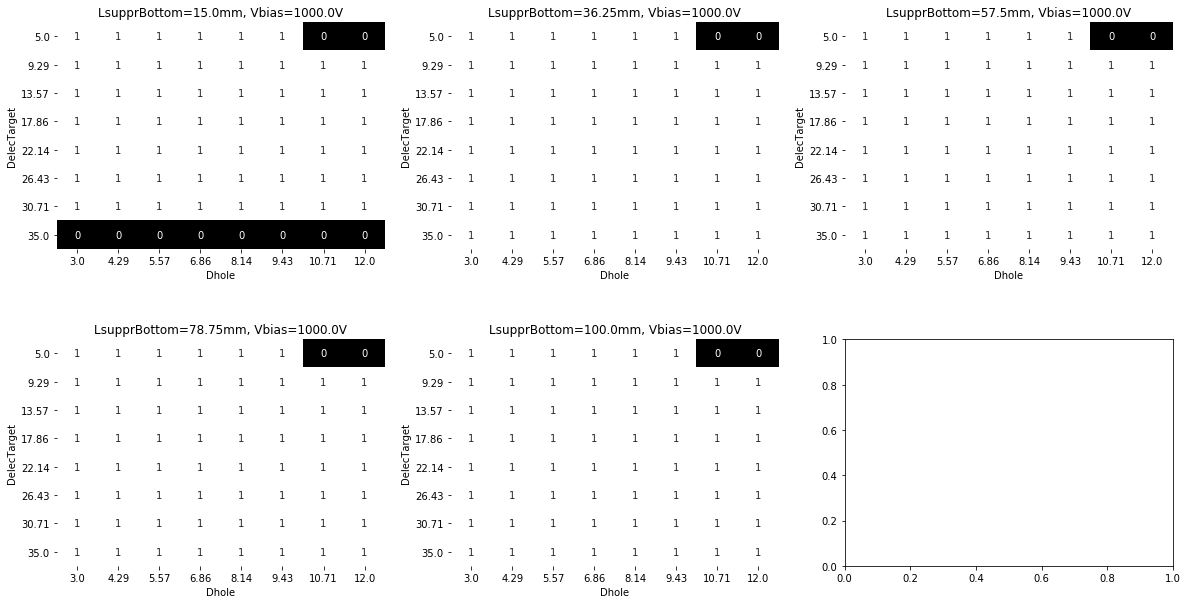

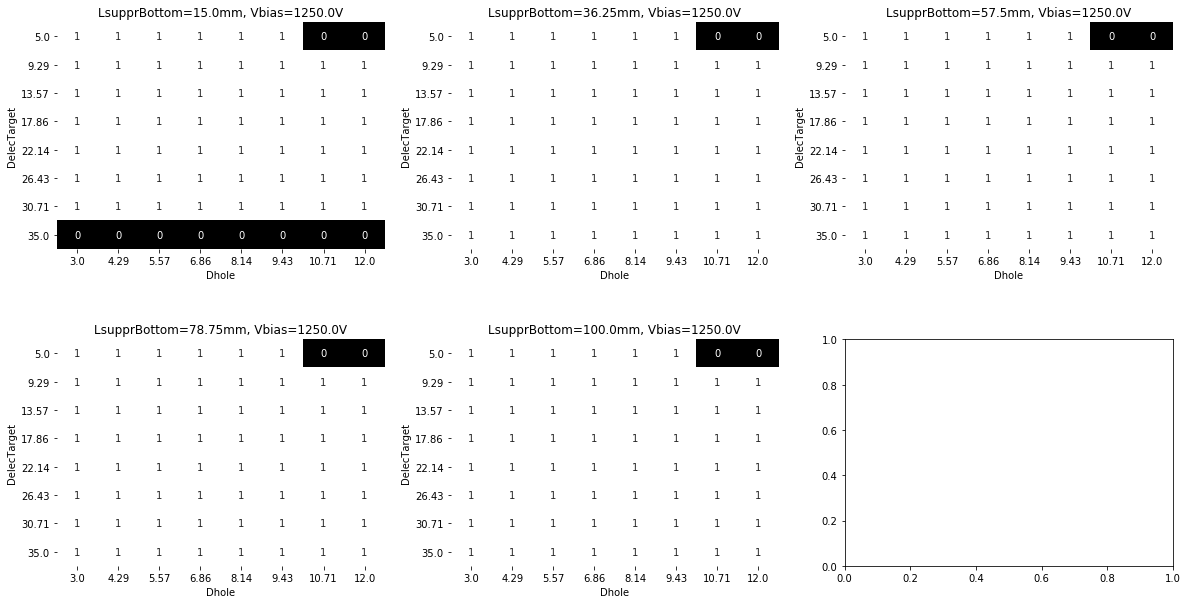

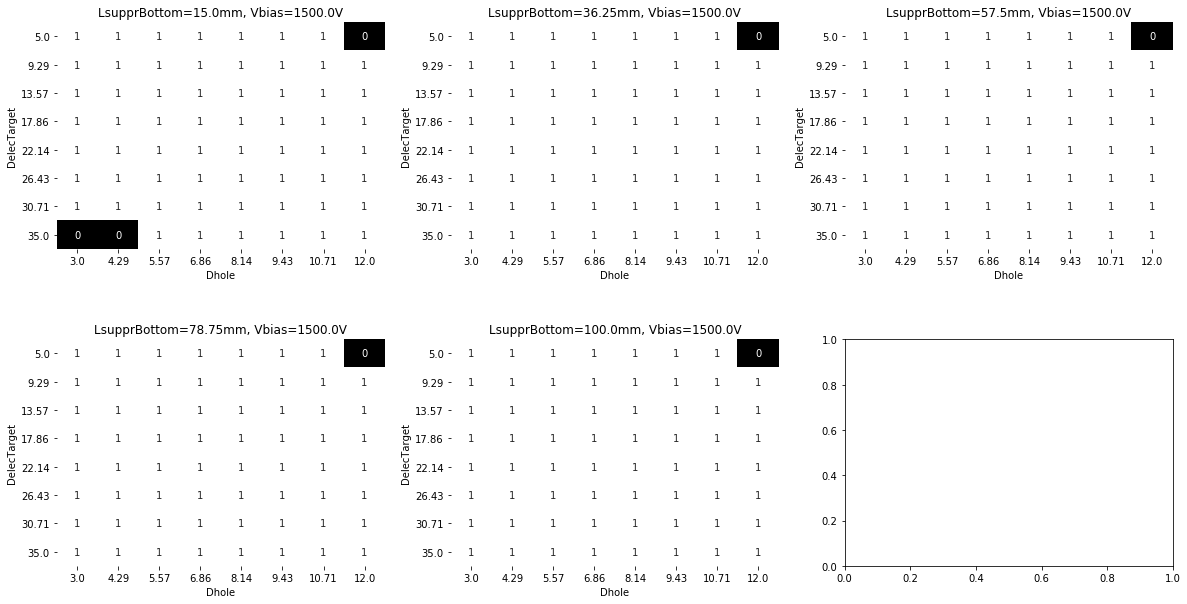

In [327]:
for df in df_suppr.groupby('V_bias'):
    V_bias = df[0]
    this_df = df[1]
    grouped = this_df.round(2).groupby('LsupprBott')
    rowlength = int(np.ceil(grouped.ngroups/2))                         # fix up if odd number of groups

    fig, axs = plt.subplots(figsize=(20,10), 
                            nrows=2, ncols=rowlength,     # fix as above
                            gridspec_kw=dict(hspace=0.4)) # Much control of gridspec

    targets = zip(grouped.groups.keys(), axs.flatten())

    for i, (key, ax) in enumerate(targets):

        g = grouped.get_group(key)

        res = pd.pivot_table(g, values='supressed', index=['DelecTarget'], columns=['Dhole'])
        sns.heatmap(res,annot=True, ax=ax,cmap='gray', cbar=False)
    #     ax.set_title(f'LsupprBottom={key}, Vbias={V_bias}V')
        ax.set_title(f'LsupprBottom={key}mm, Vbias={V_bias}V')
    plt.savefig(f'{folder}/heatmap.V_bias{V_bias}.png',dpi=600)
    plt.savefig(f'{folder}/heatmap.V_bias{V_bias}.pdf',dpi=600)
        

In [315]:
V_bias_vals = df_suppr['V_bias'].unique()
V_bias_vals

array([1000., 1250.,  750.,  500., 1500.])

In [321]:
for g_df in df_suppr.groupby('V_bias'):
    V_bias = g_df[0]
    print(V_bias)

500.0
750.0
1000.0
1250.0
1500.0
